In [2]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from typing import Callable, List

matplotlib.rcParams.update({'font.size': 18})

# Problem 1

## part (a)

The finite difference method tells us that
$$\frac{d^2x}{dt^2} = \frac{x(t+h) + x(t-h) - 2x(t)}{h^2} = -g$$
so if we rearrange we get
$$x(t) = \frac{x(t+h) + x(t-h) +gh^2}{2}$$
and now we can use the method of relaxation for this function.

In [30]:
def x(i, datapoints, h=0.1, g=9.81):
    return (datapoints[i+1] + datapoints[i-1] + g*h**2)/2

## part (b)
Set boundaries $t \in [0, 10]$ where $x(0) = x(10) = 0$ and $h=0.1$ with $\delta = 10^{-6}$.

In [31]:
delta = 1e-6
diff = 10
x_t = np.zeros(100)
while diff > delta:
    x_t2 = np.zeros(100)
    for i in range(1, 99):
        x_t2[i] = x(i, x_t)
    diff = max(abs(x_t2 - x_t))
    x_t = x_t2.copy()

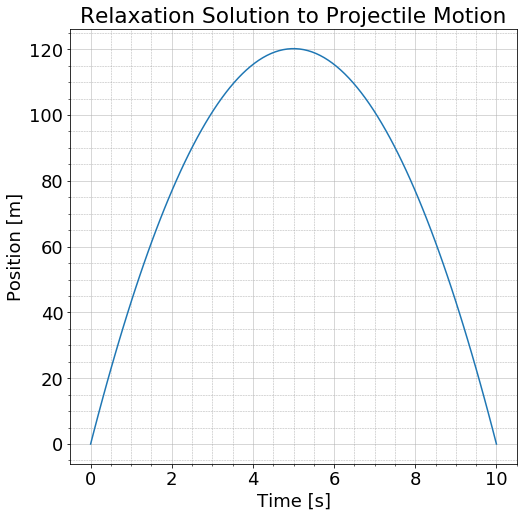

In [48]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

times = np.linspace(0, 10, 100)
ax.plot(times, x_t)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("Relaxation Solution to Projectile Motion")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.savefig("projectile.png")

# Problem 2

$$\phi(x,y) = \frac{1}{4}\left[\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) + \frac{a^2}{\epsilon_0}\rho(x,y)\right]$$

## part (a)

To calculate $\rho(x,y)$ we do the following:

In [3]:
rho_points = np.loadtxt("particles.dat")

In [4]:
def rho_over_e(x,y, rho_points=rho_points):
    xy = np.array([x,y])
    diff = xy - rho_points
    number_of_charges = ((diff <= 1) & (diff >= 0)).all(axis=1).sum()
    # Return rho(x,y)/epsilon_0 for computational feasibility
    return -1.809512651 * pow(10, -8) * number_of_charges

In [5]:
density_field = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        density_field[i,j] = rho_over_e(i,j)

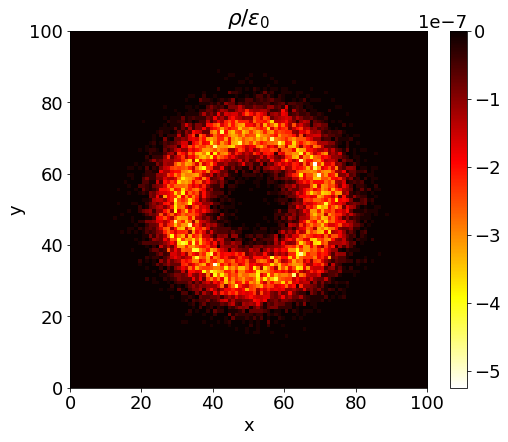

In [7]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

im = ax.imshow(density_field, origin="lower", extent=[0, 100, 0, 100], cmap="hot_r")
fig.colorbar(im, ax=ax, shrink=0.82)
ax.set_title(r"$\rho/\epsilon_0$")
ax.set_xlabel("x")
ax.set_ylabel("y");

## part (b)

In [10]:
def phi(i,j, datapoints, density_points=density_field, a=1):
    return (datapoints[i+1, j] + datapoints[i-1, j] + datapoints[i, j+1] + datapoints[i, j-1] + density_points[i,j]*a**2)/4

In [74]:
delta = 1e-10
diff = 10
phi_xy = np.zeros((100, 100))
count = 0
while diff > delta:
    count += 1
    phi_xy2 = np.zeros((100, 100))
    for i in range(1, 99):
        for j in range(1, 99):
            phi_xy2[i,j] = phi(i, j, phi_xy, density_field)
    diff = abs(phi_xy2 - phi_xy).max()
    phi_xy = phi_xy2.copy()
print(count)

11649


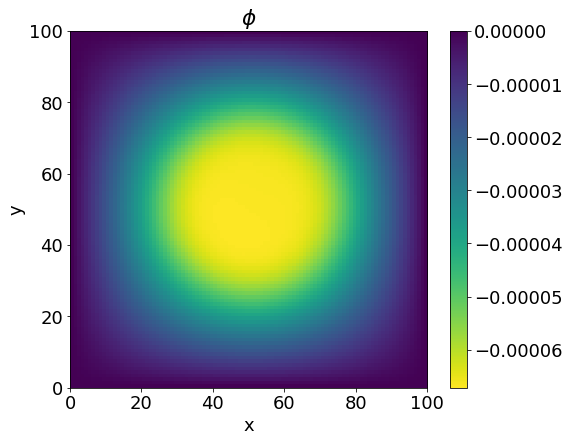

In [73]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

im = ax.imshow(phi_xy, origin="lower", extent=[0, 100, 0, 100], cmap="viridis_r")
fig.colorbar(im, ax=ax, shrink=0.82)
ax.set_title(r"$\phi$")
ax.set_xlabel("x")
ax.set_ylabel("y")


## part (c)

In [8]:
def gs_phi(i,j, datapoints, omega, density_points=density_field, a=1):
    return (1+omega)*phi(i, j, datapoints, density_points=density_points, a=a) - omega*datapoints[i,j]

### Example to ensure it works

In [12]:
delta = 1e-10
diff = 10
omega = 0.9
phi_xy = np.zeros((100, 100))
count = 0
while diff > delta:
    count += 1
    diff = 0
    for i in range(1, 99):
        for j in range(1, 99):
            new_phi_xy = gs_phi(i, j, phi_xy, omega, density_field)
            diff = max([diff, abs(new_phi_xy - phi_xy[i,j])])
            phi_xy[i,j] = new_phi_xy
print(count)

465


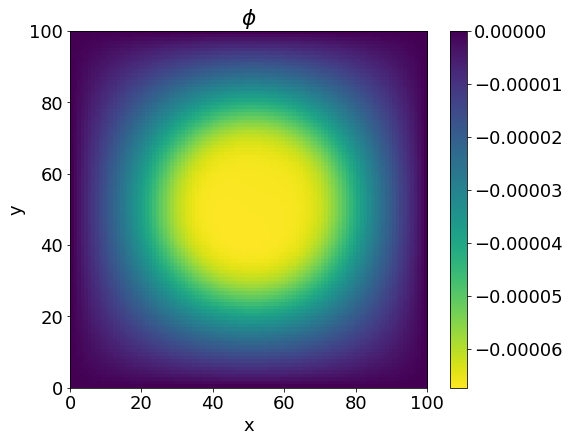

In [13]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

im = ax.imshow(phi_xy, origin="lower", extent=[0, 100, 0, 100], cmap="viridis_r")
fig.colorbar(im, ax=ax, shrink=0.82)
ax.set_title(r"$\phi$")
ax.set_xlabel("x")
ax.set_ylabel("y");

### Now optimize over $\omega$ over minimizing the number of iterations by golden ratio search

In [14]:
def evaluate_time(omega):
    delta = 1e-10
    diff = 10
    phi_xy = np.zeros((100, 100))
    count = 0
    while diff > delta:
        count += 1
        diff = 0
        for i in range(1, 99):
            for j in range(1, 99):
                new_phi_xy = gs_phi(i, j, phi_xy, omega, density_field)
                diff = max([diff, abs(new_phi_xy - phi_xy[i,j])])
                phi_xy[i,j] = new_phi_xy
    return count

In [16]:
def golden_ratio_search(func, x1, x4, delta=1e-3):
    z = (1 + np.sqrt(5))/2
    x2 = x4 - (x4 - x1)/z
    x3 = x1 + (x4 - x1)/z
    
    y1 = func(x1)
    y2 = func(x2)
    y3 = func(x3)
    y4 = func(x4)
    
    if (y2 >= y4 or y2 >= y1) and (y3 >= y4 or y3 >= y1):
        raise Exception("Bad Range to Use")
        
    w_est = [0.5*(x2 + x3)]
    
    while x4 - x1 > delta:
        if y2 < y3:
            x4 = x3
            y4 = y3
            
            x3 = x2
            y3 = y2
            
            x2 = x4 - (x4 - x1)/z
            y2 = func(x2)
        else:
            x1 = x2
            y1 = y2
            
            x2 = x3
            y2 = y3
            
            x3 = x1 + (x4 - x1)/z
            y3 = func(x3)
        w_est.append(0.5*(x2 + x3))
        print(w_est[-1])
    return w_est

In [17]:
w_points = np.linspace(0.5, 0.95, 15)
w_times = [evaluate_time(x) for x in w_points]

In [36]:
w_points2 = np.linspace(0.95, 0.99, 10)
w_times2 = [evaluate_time(x) for x in w_points2]

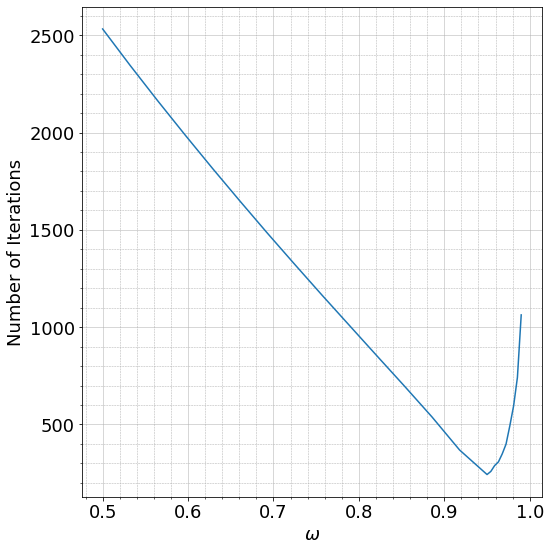

In [44]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

ax.plot(np.hstack([w_points, w_points2]), w_times + w_times2)
ax.set_title("")
ax.set_xlabel("$\omega$")
ax.set_ylabel("Number of Iterations")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()
fig.savefig("N_vs_w.png")

In [39]:
w_vals = golden_ratio_search(evaluate_time, 0.92, 0.98)

0.9385410196624968
0.9456230589874906
0.9412461179749811
0.9385410196624968
0.9402128623625221
0.9412461179749811
0.9406075308874149
0.9410021994123076
0.941246117974981


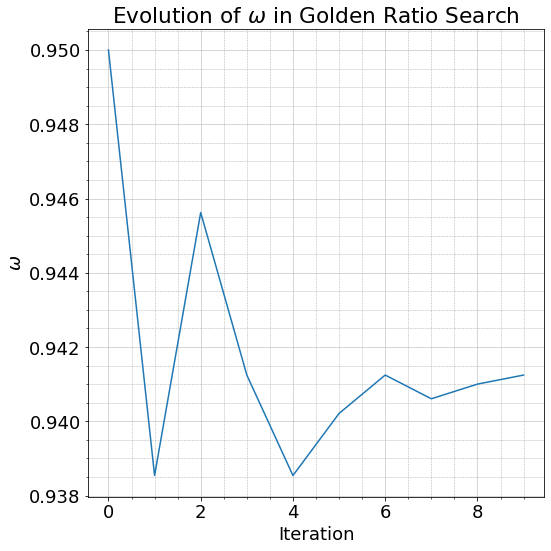

In [45]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot()

ax.plot(range(len(w_vals)), w_vals)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\omega$")
ax.set_title("Evolution of $\omega$ in Golden Ratio Search")
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5')
ax.grid(True, which='minor', linestyle='--', linewidth='0.5')
fig.tight_layout()
fig.savefig("w_evolution.png")